# Import Modules

In [49]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
import heapq
import bitarray.util as bit
import bitarray
import skimage.measure 

# Implementation

## Compress

### DCT

In [50]:
'''
DCT Function
Description:
    Calculate the transformed of a image, breaking it in bloks of 8x8
    Use two times the dct for 1D, each time for one axis of the image
Input: Original image
Output: image transformed
Warning: Need to deal with images that are not multiple of 8
'''

def DCT(img):
    Y = np.zeros_like(img)

    nLines, nCols = img.shape
    U = nLines//8
    V = nCols//8

    for u in range(U):
        for v in range(V):
            # img_blck = np.float32(imf[u*8: u*8 + 8, v*8: v*8 + 8]) # float conversion
            img_blck = img[u*8: u*8 + 8, v*8: v*8 + 8]
            Y[u*8: u*8 + 8, v*8: v*8 + 8] = cv.dct(img_blck)
    
    return Y

### DCT + Quantization

In [51]:
'''
Function: quant_DCT
Description:
    For each block 8x8 from the image transformed
    Is divided by the quantization matrix

Input: image transformed
Output: image tranformed divided by quantization 
'''

def quant_DCT(Y, quantization):
    Y_quant = np.zeros(Y.shape)
    U = Y.shape[0]//8
    V = Y.shape[1]//8

    for u in range(U):
        for v in range(V):
            Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] = (Y[u*8 : u*8 + 8, v*8 : v*8 + 8] / quantization)
    
    return Y_quant

### Huffman

In [52]:
class BinaryTree:
    def __init__(self, data):
        self.data = data
        self.right = None
        self.left = None
    def insert(self, data):
        if self.data == data:
            return
        elif self.data < data:
            if self.right is None:
                self.right = BinaryTree(data)
            else:
                self.right.insert(data)
        else: # self.data > data
            if self.left is None:
                self.left = BinaryTree(data)
            else:
                self.left.insert(data)
    def display(self):
        lines, *_ = self._display_aux()
        for line in lines:
            print(line)
    def _display_aux(self):
        """Returns list of strings, width, height, and horizontal coordinate of the root."""
        # No child.
        if self.right is None and self.left is None:
            line = '%s' % self.data
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle
        # Only left child.
        if self.right is None:
            lines, n, p, x = self.left._display_aux()
            s = '%s' % self.data
            u = len(s)
            first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s
            second_line = x * ' ' + '/' + (n - x - 1 + u) * ' '
            shifted_lines = [line + u * ' ' for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, n + u // 2
        # Only right child.
        if self.left is None:
            lines, n, p, x = self.right._display_aux()
            s = '%s' % self.data
            u = len(s)
            first_line = s + x * '_' + (n - x) * ' '
            second_line = (u + x) * ' ' + '\\' + (n - x - 1) * ' '
            shifted_lines = [u * ' ' + line for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, u // 2
        # Two children.
        left, n, p, x = self.left._display_aux()
        right, m, q, y = self.right._display_aux()
        s = '%s' % self.data
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2

In [53]:
'''
Func: weight_grey_tons
Description:
    Get the number of occurrence of each color
Input: quantizated transformed image (Future: Error quantizated transformed image)
Output: table with the occurrence of each color
    [0     4] -> color 0 -> 4 times
    [1     1] -> color 1 -> 1 time
    [2     5]
    [3     6]
'''

def weight_grey_tons(img):
    # depth = 8
    # nLine, nCols = img.shape
    # hist = np.zeros((2**8))
    
    #get unique values and counts of each value
    unique, counts = np.unique(img.flatten(), return_counts=True)

    #display unique values and counts side by side
    occurrence = np.asarray((unique, counts)).T

    return occurrence

'''
Func: huffman_tree
Description:
    Create the the tree representation for the Huff Algorithm
Input: Color occurency 
    Accept Format
    [0     4] -> color 0 -> 4 times
    [1     1] -> color 1 -> 1 time
    [2     5]
    [3     6]

Output: Tree

To-do
    Priority_queue
    Tree
'''

def huffman_tree(ocurrence):

    nLine, _ = ocurrence.shape
    
    class Tree:
        def __init__(self, data):
            self.left = None
            self.right = None
            self.data = data

    forest = []

    # Populate the list
    for i in range (nLine):
        color, times =  ocurrence[i]
        tree = BinaryTree(color)
        forest.append((times, color, tree)) # Why a tuple? Is easier to use a tuple than define a __lt__ to compare the objects

    # Create a priority list
    heapq.heapify(forest)

    # Variable to Simulate a Stable Sort
    # And to sort first the leaf with data -> (data is a value of the gray scale)
    count = 300
    while(len(forest) > 1):
        f_times, f_color, f_tree = heapq.heappop(forest)
        s_times, s_color, s_tree = heapq.heappop(forest)

        new_tree = BinaryTree(None)
        new_tree.left = f_tree
        new_tree.right = s_tree
        heapq.heappush(forest, (f_times + s_times, count, new_tree))
        count += 1
    

    _, _, h_tree = heapq.heappop(forest)

    string_to_encode = []
    
    def printPostorder(node, str):
 
        if node:
    
            # First recur on left child
            printPostorder(node.left, str)
    
            # the recur on right child
            printPostorder(node.right, str)
    
            # now print the data of node
            if node.data != None:
                str.append(1)
                str.append('c')
                str.append(np.uint8(node.data))
            else:
                str.append(0)
    

    printPostorder(h_tree, string_to_encode)
    # Mark the end of the tree
    string_to_encode.append(0)
    return h_tree, string_to_encode


In [54]:
def encode_string(arr, unique_values):
    num_bits = unique_values * 8 + unique_values * 2

    num_blocks = int(np.ceil(num_bits / 8))

    header = np.zeros((num_blocks), dtype=np.uint8)
    
    # Array index
    i = 0

    # Block Index
    k = 0

    # Index inside the Block
    j = 8

    while (i < len(arr)):

        if arr[i] == 0 or arr[i] == 1:
            header[k] += arr[i] << (j - 1)
            j -= 1
        
        elif arr[i] == 'c':
            i += 1
            
            binary = bin(arr[i])[2:]
            to_complete_8_bits = 8 - len(binary)

            for count in range(to_complete_8_bits):
                if j == 0:
                    j = 8
                    k += 1
                j -= 1
            
            for count in range(len(binary)):
                if j == 0:
                    j = 8
                    k += 1
                
                header[k] += int(binary[count]) << j - 1
                j -= 1
            

        i += 1
        if j == 0:
            j = 8
            k += 1

    return header

In [55]:
def huffman_algorithm(img):
    occurrence = weight_grey_tons(img)
    h_tree, string_to_encode = huffman_tree(occurrence)
    header = encode_string(string_to_encode, np.unique(img).size)

    return h_tree, header

In [56]:
## img codification
def pos_order(path:str, node, dictionary:dict):
    lft = node.left
    rgt = node.right

    if lft == None and rgt == None:
        dictionary[node.data] = path
    else:
        pos_order(path + '0', lft, dictionary)
        pos_order(path + '1', rgt, dictionary)

def create_dictionary(tree):
    dictionary = {}
    pos_order('', tree, dictionary)
    return dictionary

def encode_matrix(tree, matrix):
    dictionary = create_dictionary(tree)
    M, N = matrix.shape

    binaryString = ''
    for i in range(M):
        for j in range(N):
            binaryString += dictionary[matrix[i][j]]

    return bitarray.bitarray(binaryString)

In [57]:
# função para compressão
# input_image_file: arquivo de entrada contendo a imagem
# compressed_file: arquivo de saída contendo a imagem comprimida
def compress_image(input_image_file: str, compressed_file: str):
# código da função
    img = cv.imread(input_image_file, cv.IMREAD_GRAYSCALE)
    quantization_jpeg = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ])

    quantization_high_quality = np.array([
        [8, 6, 5, 8, 12, 20, 26, 31],
        [6, 6, 7, 10, 13, 29, 30, 28],
        [7, 7, 8, 12, 20, 29, 35, 28],
        [7, 9, 11, 15, 26, 44, 40, 31],
        [9, 11, 19, 28, 34, 55, 52, 39],
        [12, 18, 28, 32, 41, 52, 57, 46],
        [25, 32, 39, 44, 52, 61, 60, 51],
        [36, 46, 48, 49, 56, 50, 52, 50],
    ])

    img -= 128
    img = np.float32(img)

    dct_img = DCT(img)
    high_quant_img = np.trunc(quant_DCT(dct_img, quantization_high_quality))
    jpeg_quant_img = np.trunc(quant_DCT(dct_img, quantization_jpeg))



    # Calc Entropy   
    high_entropy = skimage.measure.shannon_entropy(high_quant_img)
    jpeg_entropy = skimage.measure.shannon_entropy(jpeg_quant_img)

    # Quantization table used
    # 0 is Jpeg Quantization table
    # 1 is High Quality quantization table
    jpeg_is_better = jpeg_entropy > high_entropy
    Q =  0 if jpeg_is_better else 1
    quant_img = jpeg_quant_img if jpeg_is_better else high_quant_img

    # Calc the huff encoding
    # Sum 128 to convert all numbers to positive
    quant_img += 128

    if quant_img.min() < 0 or quant_img.max() > 255:
        exit(3)
        
    tree, huff_codification = huffman_algorithm(quant_img)

    # Create the header
    header = np.zeros((1 + 4 + 4 + 2 + huff_codification.size), dtype=np.uint8)
    header[0] = Q
    print('Tamanho Huffman::', huff_codification.size)
    N, M = quant_img.shape

    # Number of lines
    N_bin = bin(N)[2:]
    N_bin = '0' * (32 - len(N_bin)) + N_bin
    for i in range(1, 1 + 4):
        for j in range(8):
            header[i] += int(N_bin[8*(i - 1) + j]) << 8 - (j+1)
    
    # Number of columns
    M_bin = bin(M)[2:]
    M_bin = '0' * (32 - len(M_bin)) + M_bin
    for i in range(5, 1 + 4 + 4):
        for j in range(8):
            header[i] += int(M_bin[8* (i - 5) + j]) << 8 - (j+1)
    
    
    # Number of bytes in the huffman encoding
    size_enconding = huff_codification.size
    size_enconding_bin = bin(size_enconding)[2:]
    size_enconding_bin = '0' * (16 - len(size_enconding_bin)) + size_enconding_bin

    for i in range(9, 1 + 4 + 4 + 2):
        for j in range(8):
            header[i] += int(size_enconding_bin[8* (i - 9) + j]) << 8 - (j+1)

    
    # Copy huffman Encoding
    for i in range(11, 11 + huff_codification.size):
        header[i] = huff_codification[i - 11]

    # Crete the img Codification (Alves)
    encodedImg = encode_matrix(tree, quant_img)

    #Create compressed binary file
    outFile = open(compressed_file, 'wb')

    for byte in header:
        outFile.write(byte)
    outFile.write(encodedImg)

    outFile.close()
    

## Decompress

### Huffman

In [58]:
def uncode_header(header):
    stack = []

    # Block Index
    k = 0

    # Index inside the Block
    j = 0

    color = 0


    # Complete with zeros binaries less than 8 bits
    def binary_8bits(num):
        binary = bin(num)[2:]
        binary = '0' * (8 - len(binary)) + binary
        return binary
    
    def increase_j(j):
        j_equal_eight = j == 7
        j = 0 if j_equal_eight else j + 1
        return j, j_equal_eight
    
    def change_block(j, k, bits):
        j, change_block = increase_j(j)
        if change_block:
            k += 1
            bits = binary_8bits(header[k])
        
        return j, k, bits

    binary = binary_8bits(header[0])
    
    while True:
        if int(binary[j]) == 1:
            print('ok')
            j, k, binary = change_block(j, k, binary)
                        
            for i in range(8):
                color = (color << 1) + int(binary[j])
                j, k, binary = change_block(j, k, binary)    

            stack.append(BinaryTree(color))
            color = 0
            print(j, k, binary)
        
        elif int(binary[j]) == 0:
            if (len(stack) > 1):
                last_tree = stack.pop()
                before_last_tree = stack.pop()

                new_tree = BinaryTree(None)
                new_tree.left = before_last_tree
                new_tree.right = last_tree

                stack.append(new_tree)
                j, k, binary = change_block(j, k, binary)

            else:
                return stack[0]

In [59]:
def dequant_DCT(Y_quant, quantization):
    U = Y_quant.shape[0]//8
    V = Y_quant.shape[1]//8
    Y_dequant = np.zeros(Y_quant.shape)
    
    for u in range(U):
        for v in range(V):
            Y_dequant[u*8 : u*8 + 8, v*8 : v*8 + 8] = Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] * quantization
    
    return Y_dequant



In [60]:
def iDCT(Y):

    U = Y.shape[0]//8
    V = Y.shape[1]//8
    img_rec = np.zeros(Y.shape)
    for u in range(U):
        for v in range(V):
            img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = cv.idct(Y[u*8 : u*8 + 8, v*8 : v*8 + 8])
    
    return img_rec

In [61]:
def concatBytes(list):
    binStr = ''
    for i in range(len(list)):
        byte = bin(list[i])[2:]
        byte = '0' * (8 - len(byte)) + byte 
        binStr += byte

    bitArr = bitarray.bitarray(binStr)
    dic = {
        "bitarray": bitArr,
        "int": bit.ba2int(bitArr)
    }
    return dic

In [62]:
# função para descompressão
# compressed_file: arquivo contendo a imagem comprimida
# output_image_file: arquivo contendo a imagem reconstruída
def decompress_image(compressed_file: str, output_image_file: str):
    output = open(output_image_file, 'wb')

    with open(compressed_file, 'rb') as f:
        quantization = f.read(1)[0]
        M = concatBytes(f.read(4))
        N = concatBytes(f.read(4))
        hoofmanLen = concatBytes(f.read(2))['int']
        print(f'A matriz de quantização escolhida eh: {quantization}')
        print(f'Seu tamanho eh (M x N): ({(M["int"])}, {N["int"]})')
        print(f'Tamanho do Hoofman eh: {hoofmanLen} bytes')

        hoofman = concatBytes(f.read(hoofmanLen))
        print(f'Hoofman: {hoofman["bitarray"]}')


        # while True:
        #     byte_s = f.read(1)
        #     print(byte_s)
        #     if not byte_s:

        #         break
        #     byte = byte_s[0]

compress_image('imgs/horizon.png', 'compressed.bin')
decompress_image('compressed.bin', 'out.jpg')

Tamanho Huffman:: 457
A matriz de quantização escolhida eh: 1
Seu tamanho eh (M x N): (1080, 1920)
Tamanho do Hoofman eh: 457 bytes
Hoofman: bitarray('100101011110000001110001011101100011101000011001011110011011000011011000111011001100110100110110101111001110000111001101100100110010000001100001001100100011101001001111111101001001110101001010101110111101001110000110010101000101010100000110001010101001110010101110001011000001001111010010100011010100000110011110001010010111010110100000000101111100110110100101011111110101101001011100100101001111010101011010100010000010100100010100100101010011001001111110010101100110101011101101000101011000001010110111101001010011100000111100011001001001001110011001110101110000010101111100001001110111010011011110110011111011000111111101100010011001001100101001110100101000110101001000001010011111110110100111011011111011101000011110000011110010001111010111111100010011111001111111010101111110011000000000001000000011000000110100001110100001111001000100001000101

# Execution and Test

## Load Image

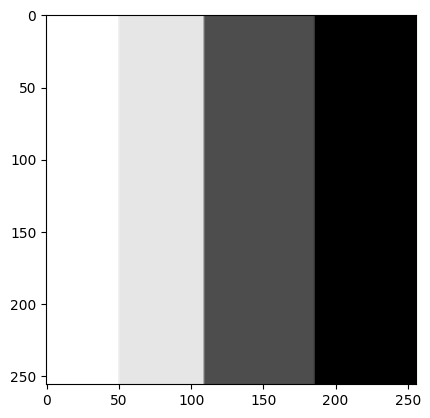

In [63]:
img = cv.imread('imgs/listrada.png', cv.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [64]:
compression(img)

NameError: name 'compression' is not defined

## Compress


### DCT

In [ ]:
imf = np.float32(img) - 128
Y = DCT(imf)

In [ ]:
plt.imshow((Y), cmap='gray')
(np.unique(Y).size, np.unique(img).size)

### Quantizando

In [ ]:
Y_quant = quant_DCT(Y)
# Y_quant = np.round(quant_DCT(Y))
Y_quant = np.trunc(quant_DCT(Y))
# Y_quant += 128
# plt.hist(Y_quant)
x = 0

In [ ]:

nums = np.unique(Y_quant)
print(f'Imagem Original: {np.unique(img).size}    |     Imagem Tranformada Quantizada: {np.unique(Y_quant).size}')
print(f'Numero de Zeros na Imagem {(Y_quant == 0).sum()},  Numero de Pixels da Imagem {img.size}')
print(f'rate: {(Y_quant == 0).sum() / img.size}')

### Huffman

In [ ]:
#get unique values and counts of each value
unique, counts = np.unique(img, return_counts=True)

#display unique values and counts side by side
print(np.asarray((np.uint8(unique), counts)).T)
print(unique.min(), unique.max())

In [ ]:
output = weight_grey_tons(img)
tree, to_encode = huffman_tree(output)
tree.display()
print()
print(to_encode)

In [ ]:


header = encode_string(to_encode, np.unique(img).size)
header
for i in range(len(header)):
    print(bin(header[i]))

In [ ]:
plt.hist(img, density=True)
x = 0

## Unconpress

In [ ]:
tree.display()

In [ ]:
for i in range(len(header)):
    print(bin(header[i]))
header

In [ ]:
binary = bin(header[1])[2:]
binary = '0' * (8 - len(binary)) + binary
binary

### Huffman

In [ ]:
huffman_tree_uncoded = uncode_header(header)
huffman_tree_uncoded.display()

In [ ]:
tree.display()

### Dequantizando

In [ ]:
Y_dequant = dequant_DCT(Y_quant)
np.unique(Y_dequant).max()

### Transformada inversa

In [ ]:
img_rec = iDCT(Y_dequant)
img_rec += 128

# Corrige os pixies que estouraram
filtro = img_rec > 255
img_rec[filtro] = 255

filtro = img_rec < 0
img_rec[filtro] = 0
# img_rec *= rate
img_rec = np.round(img_rec)

In [ ]:
plt.imshow((img_rec), cmap='gray')

In [ ]:
plt.imshow((img), cmap='gray')

# Análises


In [ ]:
print(f'MSE: {((img - img_rec)**2).sum()/img.size}')
print(f'ME: {np.abs(img - img_rec).max()}')

In [ ]:
# histogramas de Y e Y_quant para, posteriormente, criar matriz de erros para huffman
# observe o eixo-x, i.e. os erros serão mais próximos
plt.hist(Y)
plt.show()
plt.hist(Y_quant)
plt.show()

In [ ]:
(np.unique(Y).size, np.unique(Y_quant).size)